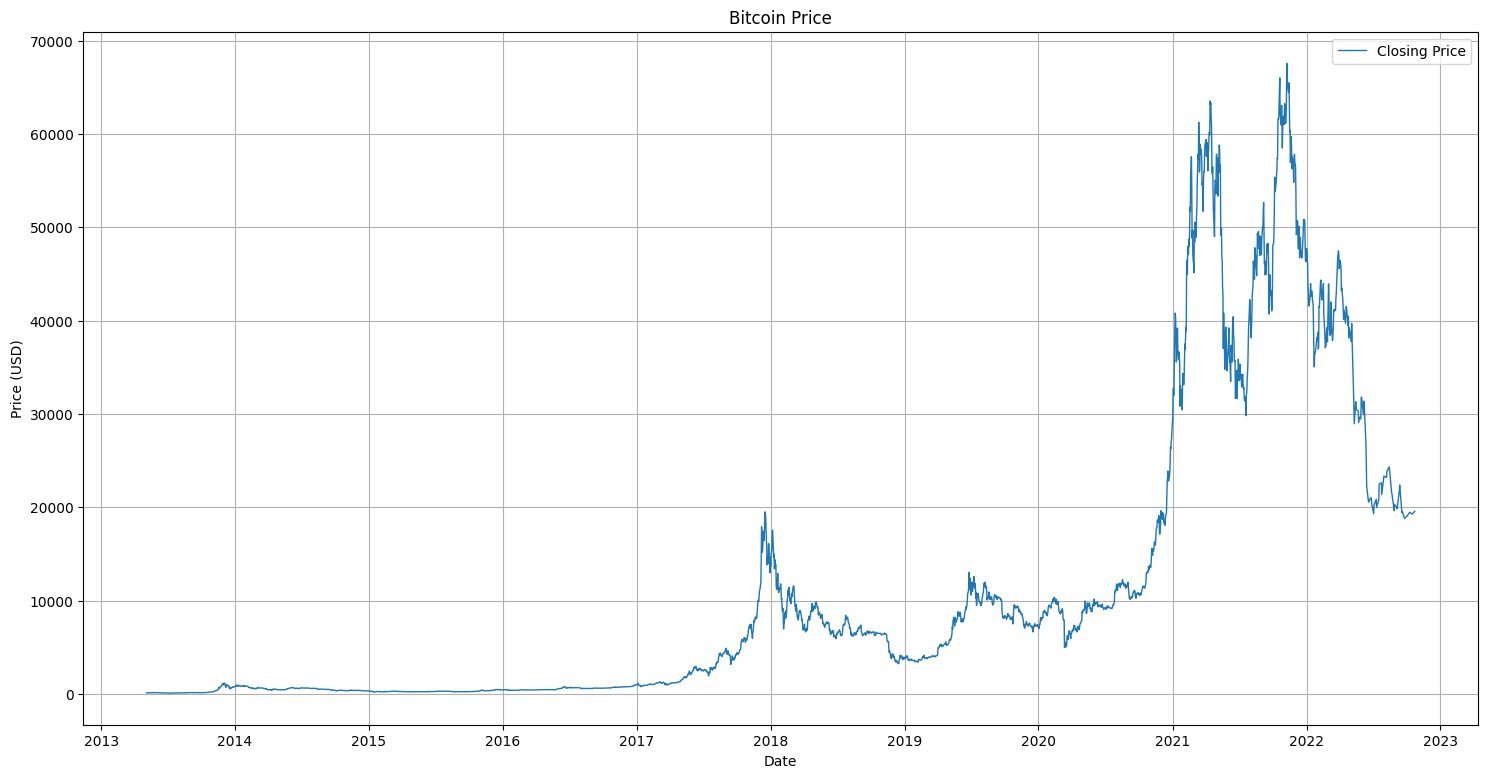

/var/folders/pn/sv2_pvns5zz340mv_14h10980000gp/T/ipykernel_66432/1423672249.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_df['daily_return'] = bitcoin_df['close'].pct_change()
/var/folders/pn/sv2_pvns5zz340mv_14h10980000gp/T/ipykernel_66432/1423672249.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_df['volatility_3d'] = bitcoin_df['daily_return'].rolling(window=3).std()
/var/folders/pn/sv2_pvns5zz340mv_14h10980000gp/T/ipykernel_66432/1423672249.py:64: SettingWithCopyWarning: 
A v

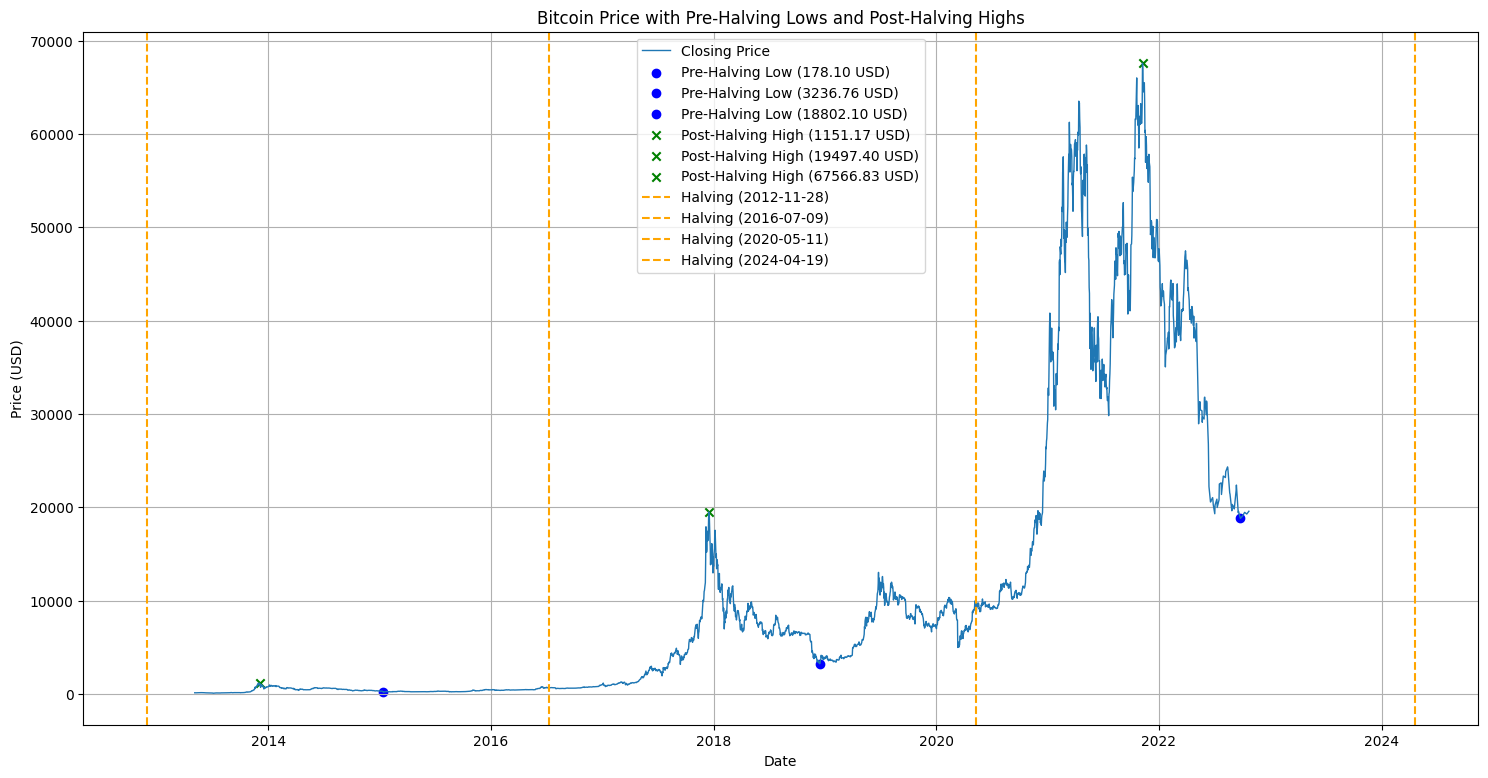

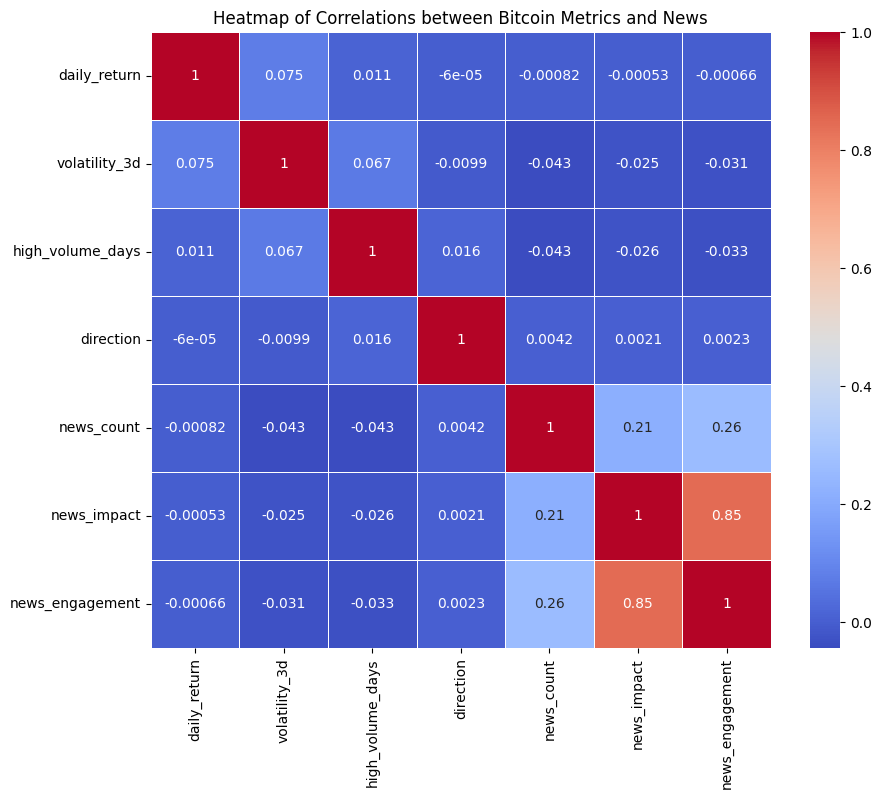

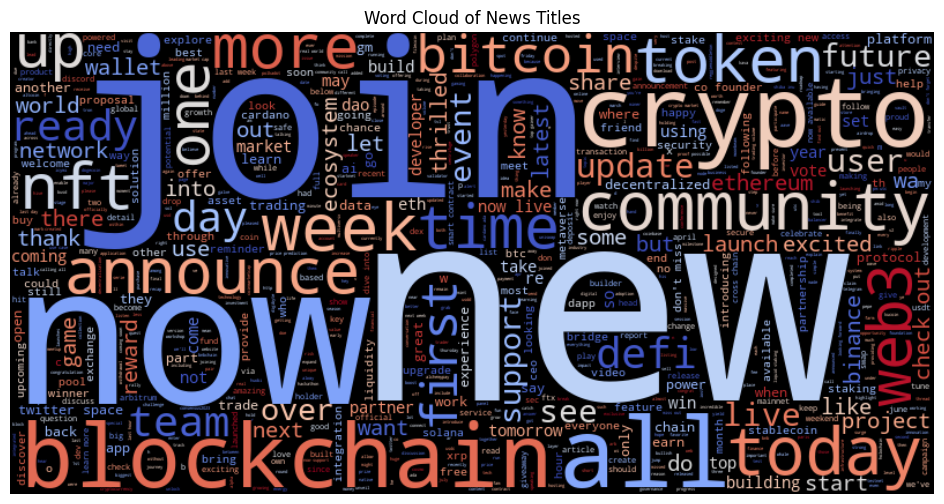

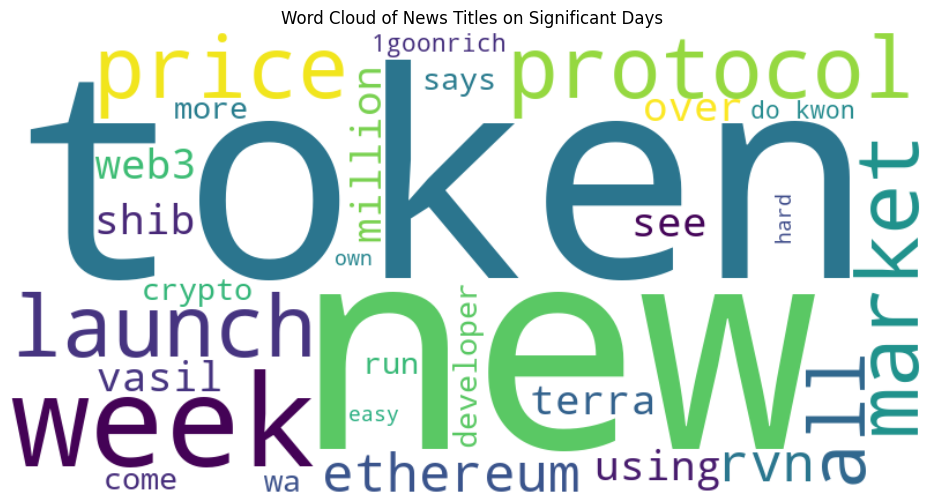

In [24]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# Load the datasets
prices_df = pd.read_csv('dataset.csv')
news_df = pd.read_csv('cryptopanic_news.csv')

# -------------------------------
# Step 1: Data Preparation
# -------------------------------

# Convert 'date' column to datetime format in the prices dataset
prices_df['date'] = pd.to_datetime(prices_df['date'])
prices_df = prices_df.set_index('date').sort_index()

# Convert 'date' column to datetime format in the news dataset
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
news_df = news_df.dropna(subset=['date'])
news_df = news_df.set_index('date').sort_index()

# Filter the prices dataset for Bitcoin only
bitcoin_df = prices_df[prices_df['crypto_name'] == 'Bitcoin']

# -------------------------------
# Step 2: Plot Bitcoin Prices
# -------------------------------

# Plot Bitcoin closing prices
plt.figure(figsize=(18, 9))
plt.plot(bitcoin_df.index, bitcoin_df['close'], label='Closing Price', linewidth=1)
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------
# Step 3: Calculate Metrics
# -------------------------------

# Calculate daily returns
bitcoin_df['daily_return'] = bitcoin_df['close'].pct_change()

# Calculate 3-day volatility
bitcoin_df['volatility_3d'] = bitcoin_df['daily_return'].rolling(window=3).std()

# Identify high volatility (above the 95th percentile)
volatility_threshold = bitcoin_df['volatility_3d'].quantile(0.95)
high_volatility = bitcoin_df[bitcoin_df['volatility_3d'] > volatility_threshold]

# Identify high volume days (above the 95th percentile)
volume_threshold = bitcoin_df['volume'].quantile(0.95)
high_volume_days = bitcoin_df[bitcoin_df['volume'] > volume_threshold]

# Identify significant price changes (greater than 15%)
significant_changes = bitcoin_df[bitcoin_df['daily_return'].abs() > 0.15]

# Add price direction (positive or negative)
bitcoin_df['direction'] = bitcoin_df['daily_return'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

# -------------------------------
# Step 4: Halving Analysis
# -------------------------------

# Bitcoin halving dates
halving_dates = [
    pd.Timestamp('2012-11-28'),
    pd.Timestamp('2016-07-09'),
    pd.Timestamp('2020-05-11'),
    pd.Timestamp('2024-04-19')  # Estimated next halving
]

# Find the lowest price within 3 years before each halving
pre_halving_lows = {}
for halving_date in halving_dates:
    start_date = halving_date - pd.DateOffset(years=2)
    valid_data = bitcoin_df[start_date:halving_date]
    if not valid_data.empty:
        pre_halving_low = valid_data['close'].idxmin()
        pre_halving_lows[halving_date] = pre_halving_low

# Find the highest price within 3 years after each halving
post_halving_highs = {}
for halving_date in halving_dates:
    end_date = halving_date + pd.DateOffset(years=2)
    valid_data = bitcoin_df[halving_date:end_date]
    if not valid_data.empty:
        post_halving_high = valid_data['close'].idxmax()
        post_halving_highs[halving_date] = post_halving_high

# -------------------------------
# Step 5: Plot with Halvings, Minima, and Maxima
# -------------------------------

# Plot Bitcoin prices with pre-halving lows and post-halving highs
plt.figure(figsize=(18, 9))
plt.plot(bitcoin_df.index, bitcoin_df['close'], label='Closing Price', linewidth=1)

# Mark pre-halving lows
for halving, low_date in pre_halving_lows.items():
    price = bitcoin_df['close'].loc[low_date]
    plt.scatter(low_date, price, color='blue', marker='o', label=f'Pre-Halving Low ({price:.2f} USD)')

# Mark post-halving highs
for halving, high_date in post_halving_highs.items():
    price = bitcoin_df['close'].loc[high_date]
    plt.scatter(high_date, price, color='green', marker='x', label=f'Post-Halving High ({price:.2f} USD)')

# Mark halving dates
for halving in halving_dates:
    plt.axvline(halving, color='orange', linestyle='--', label=f'Halving ({halving.date()})')

# Plot details
plt.title('Bitcoin Price with Pre-Halving Lows and Post-Halving Highs')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()


# -------------------------------
# Step 6: Align Data to Overlapping Timeframe
# -------------------------------

# Define the overlapping timeframe
start_date = pd.Timestamp('2022-09-06')
end_date = pd.Timestamp('2023-10-23')

# Filter both datasets to the overlapping timeframe
bitcoin_df = bitcoin_df.loc[start_date:end_date]
news_df = news_df.loc[start_date:end_date]

# -------------------------------
# Step 6: Correlation with News Data
# -------------------------------

# Count the number of news articles per day
news_daily_count = news_df.resample('D').size().rename('news_count')

# Calculate the impact: (positive + negative) * important (weight = +1)
news_df['adjusted_important'] = news_df['important'] + 1
news_df['impact'] = (news_df['positive'] - news_df['negative']) * news_df['adjusted_important']
news_df['engagement'] = (news_df['liked'] * news_df['adjusted_important']) - (news_df['disliked'] * news_df['adjusted_important'])

# Sum the impact per day
news_daily_impact = news_df['impact'].resample('D').sum()
news_daily_engagement = news_df['engagement'].resample('D').sum()
high_volume_days = high_volume_days['volume'].resample('D').sum()
direction = bitcoin_df['direction'].map({'Positive': 1, 'Negative': -1}).resample('D').sum()

combined_df = pd.DataFrame({
    'daily_return': significant_changes['daily_return'].resample('D').sum(),
    'volatility_3d': high_volatility['volatility_3d'].resample('D').sum(),
    'high_volume_days': high_volume_days,
    'direction': direction,
    'news_count': news_daily_count,
    'news_impact': news_daily_impact,
    'news_engagement': news_daily_engagement
}).fillna(0)

# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Plot the heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlations between Bitcoin Metrics and News')
plt.show()


# -------------------------------
# Now let's filter News for Significant Days
# -------------------------------

# -------------------------------
# Identify Significant Days
# -------------------------------

# Combine all significant days into one DataFrame
significant_days = pd.concat([high_volatility, significant_changes, high_volume_days]).sort_index().drop_duplicates()

# Extract the dates of the significant days
significant_dates = significant_days.index.date

# Filter the news for these dates
significant_news = news_df[news_df.index.normalize().isin(pd.to_datetime(significant_dates))]

# Define the list of casual words to exclude
casual_words = [
    'the', 'a', 'in', 'per', 'rt', 'on', 'for', 'of', 'is', 'to', 'and', 'with',
    'you', 'are', 'we', 'as', 'our', 'this', 'will', 'at', 'be', 'your', 'by',
    'from', '-', 'has', 'that', 'have', '&amp;', 'can', 'it', 'an', 'about',
    'how', 'us', 'get', 'what', 'been', "we're", 'here', 'than', 'rly', 'their',
    '(2022-06-16)', '( 2022-06-16 )', 'S', 'did', 'amp', 'or', 'which', 'its',
    't', 'why', 'any', 'after', 'ama', 'robo-01', 'these', 'i', 'hi', 'if'
]

# Concatenate all the titles into a single string
titles_text = ' '.join(news_df['title'].dropna().str.lower())

# Generate the ALL TITLES word cloud while excluding the casual words
wordcloud = WordCloud(stopwords=set(casual_words), width=800, height=400, background_color='black',colormap='coolwarm', max_words=3000).generate(titles_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Titles')
plt.show()

# Concatenate all the titles into a single string
significant_titles_text = ' '.join(significant_news['title'].dropna().str.lower())

# Generate word cloud while excluding the casual words
wordcloud = WordCloud(stopwords=set(casual_words), width=800, height=400, background_color='white',colormap='viridis', max_words=30).generate(significant_titles_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Titles on Significant Days')
plt.show()